<a href="https://colab.research.google.com/github/FORMAS/PTOIE-Dep/blob/fixes/Noie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

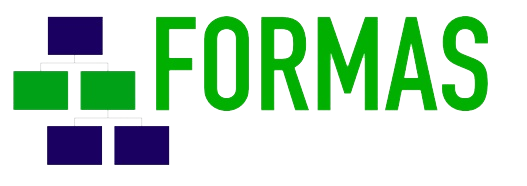
# RESEARCH GROUP
## Noie
### An Open Information Extraction System based on Dependency Parser and Handcrafted Rules for Portuguese texts inspired by ClausIE 

https://formas.ufba.br/

How to cite us:

?

In [ ]:
!pip install lemminflect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 769 kB 8.4 MB/s 


In [ ]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 574 kB 8.2 MB/s 
     |████████████████████████████████| 4.2 MB 45.4 MB/s 
     |████████████████████████████████| 175 kB 50.1 MB/s 
     |████████████████████████████████| 6.6 MB 45.1 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=06a49a2eec7ed186f80f65cbbb9f22e5914d4c14a9a5495a74ea120f740176e6
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install spacy_stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.2 MB 7.8 MB/s 
     |████████████████████████████████| 457 kB 40.2 MB/s 
     |████████████████████████████████| 181 kB 39.7 MB/s 
     |████████████████████████████████| 10.1 MB 41.0 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 660 kB 55.7 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srs

In [ ]:
import stanza
stanza.download('pt', package='bosque')

2022-06-05 17:37:43 INFO: Downloading these customized packages for language: pt (Portuguese)...
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |
| depparse  | bosque  |
| pretrain  | bosque  |

INFO:stanza:Downloading these customized packages for language: pt (Portuguese)...
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |
| depparse  | bosque  |
| pretrain  | bosque  |



2022-06-05 17:37:55 INFO: Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  6 18:07:24 2019

@author: Emmanouil Theofanis Chourdakis

Clausie as a spacy library

History

Rafael Glauber - rafaelglauber@gmail.com
- 2021/11/19 
- Source code compatible with spacy 3 (stanza models) and handcrafted rules for Portuguese Language.

"""

from numpy import right_shift
import spacy
import lemminflect
import logging
import typing
import stanza
import spacy_stanza

from spacy.language import Language
from spacy.tokens import Span, Doc
from spacy.matcher import Matcher
from lemminflect import getInflection

logging.basicConfig(level=logging.INFO)

Doc.set_extension("clauses", default=[], force=True)
Span.set_extension("clauses", default=[], force=True)

SUBJECT_DEPREL = ['nsubj', 'nsubj:pass']
IOBJECT_DEPREL = ['iobj']
DOBJECT_DEPREL = ['obj']
COMPLEMENT_DEPREL = ['ccomp', 'xcomp', 'amod', 'nmod', 'nummod']
ADVERBIAL_DEPREL = ['advcl', 'advmod', 'obl', 'obl:agent']
COPULAR_DEPREL = ['cop']
APPOSITIVE_DEPREL = ['appos']
CONJ_DEPREL = ['conj']

RELATIVE_PRONOUN = ['qual', 'cujo', 'quanto', 'que', 'quem', 'onde']

PRONOUN_POS = 'PRON'
VERB_POS = 'VERB'

# aux verb to appos modifier (synthetic relationship)
TOBE_VERB = 'é'

class Clause:
        
    def __init__(
        self,
        subject: typing.Optional[Span] = None,
        verb: typing.Optional[Span] = None,
        indirect_object: typing.Optional[Span] = None,
        direct_object: typing.Optional[Span] = None,
        complement: typing.Optional[Span] = None,
        adverbials: typing.List[Span] = None,
    ):
        """
        Parameters
        ----------
        subject : Span
            Subject.
        verb : Span
            Verb.
        indirect_object : Span, optional
            Indirect object, The default is None.
        direct_object : Span, optional
            Direct object. The default is None.
        complement : Span, optional
            Complement. The default is None.
        adverbials : list, optional
            List of adverbials. The default is [].

        Returns
        -------
        None.

        """
        if adverbials is None:
            adverbials = []

        self.subject = subject
        self.verb = verb
        self.indirect_object = indirect_object
        self.direct_object = direct_object
        self.complement = complement
        self.adverbials = adverbials

        self.doc = self.subject.doc

        self.type = self._get_clause_type()

    def _get_clause_type(self):
        has_verb = self.verb is not None
        has_complement = self.complement is not None
        has_adverbial = len(self.adverbials) > 0
        has_direct_object = self.direct_object is not None
        has_indirect_object = self.indirect_object is not None
        has_object = has_direct_object or has_indirect_object
        
        clause_type = "undefined"

        if not has_verb:
            clause_type = "SVC"
            return clause_type

        if has_object:
            if has_direct_object and has_indirect_object:
                clause_type = "SVOO"
            elif has_complement:
                clause_type = "SVOC"
            elif not has_adverbial or not has_direct_object:
                clause_type = "SVO"
            elif has_adverbial:
                clause_type = "SVOA"
            else:
                clause_type = "SVO"
        else:
            if has_complement:
                clause_type = "SVC"
            elif not has_adverbial:
                clause_type = "SV"
            elif has_adverbial:
                clause_type = "SVA"
            else:
                clause_type = "SV"

        return clause_type

    def __repr__(self):
        return "<{}, {}, {}, {}, {}, {}, {}>".format(
            self.type,
            self.subject,
            self.verb,
            self.indirect_object,
            self.direct_object,
            self.complement,
            self.adverbials,
        )

    def to_propositions(
        self, as_text: bool = False, inflect: str or None = "VBD", capitalize: bool = False
    ):

        if inflect and not as_text:
            logging.warning("`inflect' argument is ignored when `as_text==False'. To suppress this warning call `to_propositions' with the argument `inflect=None'")
        if capitalize and not as_text:
            logging.warning("`capitalize' argument is ignored when `as_text==False'. To suppress this warning call `to_propositions' with the argument `capitalize=False")

        propositions = []

        subjects = extract_ccs_from_token_at_root(self.subject)
        direct_objects = extract_ccs_from_token_at_root(self.direct_object)
        indirect_objects = extract_ccs_from_token_at_root(self.indirect_object)
        complements = extract_ccs_from_token_at_root(self.complement)
        verbs = [self.verb] if self.verb else []
        
        # synthetic verb
        tobe_verb = nlp(TOBE_VERB)

        for subj in subjects:
            if complements and not verbs:
                for c in complements:
                    propositions.append((subj, tobe_verb, c))
                propositions.append((subj, tobe_verb) + tuple(complements))

            for verb in verbs:
                prop = [subj, verb]
                if self.type in ["SV", "SVA"]:
                    if self.adverbials:
                        for a in self.adverbials:
                            propositions.append(tuple(prop + [a]))
                        propositions.append(tuple(prop + self.adverbials))
                    else:
                        propositions.append(tuple(prop))

                elif self.type == "SVOO":
                    for iobj in indirect_objects:
                        for dobj in direct_objects:
                            propositions.append((subj, verb, iobj, dobj))
                elif self.type == "SVO":
                    for obj in direct_objects + indirect_objects:
                        propositions.append((subj, verb, obj))
                        for a in self.adverbials:
                            propositions.append((subj, verb, obj, a))
                elif self.type == "SVOA":
                    for obj in direct_objects:
                        if self.adverbials:
                            for a in self.adverbials:
                                propositions.append(tuple(prop + [obj, a]))
                            propositions.append(tuple(prop + [obj] + self.adverbials))

                elif self.type == "SVOC":
                    for obj in indirect_objects + direct_objects:
                        if complements:
                            for c in complements:
                                propositions.append(tuple(prop + [obj, c]))
                            propositions.append(tuple(prop + [obj] + complements))
                elif self.type == "SVC":
                    if complements:
                        for c in complements:
                            propositions.append(tuple(prop + [c]))
                        propositions.append(tuple(prop + complements))

        # Remove doubles
        propositions = list(set(propositions))

        if as_text:
            return _convert_clauses_to_text(
                propositions, inflect=inflect, capitalize=capitalize
            )

        return propositions

def inflect_token(token, inflect):
    if (
        inflect
        and token.pos_ == "VERB"
        and "AUX" not in [tt.pos_ for tt in token.lefts]
        # t is not preceded by an auxiliary verb (e.g. `the birds were ailing`)
    ):  # t `dreamed of becoming a dancer`
        return str(token._.inflect(inflect))
    else:
        return str(token)


def _convert_clauses_to_text(propositions, inflect, capitalize):
    proposition_texts = []
    for proposition in propositions:
        span_texts = []
        for span in proposition:

            token_texts = []
            for token in span:
                token_texts.append(inflect_token(token, inflect))

            span_texts.append(" ".join(token_texts))
        proposition_texts.append(" ".join(span_texts))

    if capitalize:  # Capitalize and add a full stop.
        proposition_texts = [text.capitalize() + "." for text in proposition_texts]

    return proposition_texts


def _get_verb_matches(span):
    # 1. Find verb phrases in the span
    # (see mdmjsh answer here: https://stackoverflow.com/questions/47856247/extract-verb-phrases-using-spacy)
    verb_matcher = Matcher(span.vocab)
    pattern = [
        #[{"POS": "AUX"}], 
        #[{"POS": "VERB"}], 
        #[{"POS": "VERB", "OP": "+"}], 
        [{"POS": "AUX", "OP": "+"}, 
        {"POS": "VERB", "OP": "*"}, 
        {"POS": "ADV", "OP": "*"}, 
        {"POS": "ADJ", "OP": "*"}, 
        {"POS": "DET", "OP": "*"}, 
        {"POS": "NOUN", "OP": "*"}], 
        [{"POS": "VERB", "OP": "+"}, 
        {"POS": "ADV", "OP": "*"}, 
        {"POS": "ADJ", "OP": "*"}, 
        {"POS": "DET", "OP": "*"}, 
        {"POS": "NOUN", "OP": "*"}] 
        #[{"POS": "AUX"}, {"POS": "NOUN"}],
        #[{"POS": "AUX"}, {"POS": "DET"}, {"POS": "NOUN"}]
        ]
    verb_matcher.add("Verb phrase",  pattern)
    return verb_matcher(span)


def _get_verb_chunks(span):
    matches = _get_verb_matches(span)

    # Filter matches (e.g. do not have both "has won" and "won" in verbs)
    verb_chunks = []
    for match in [span[start:end] for _, start, end in matches]:
        if match.root not in [vp.root for vp in verb_chunks]:
            verb_chunks.append(match)
    return verb_chunks


def _get_subject(verb):    
    # get verb root token
    root = verb.root
    
    # if it is a copulate verb, we should climb the tree.
    if root.dep_ in COPULAR_DEPREL:
        children = root.head.children
    else:
        children = verb.root.children       
    
    # default subject in SV format
    for c in children:
        if c.dep_ in SUBJECT_DEPREL:
            subject = extract_span_from_entity(c)
            # if relative pronoun: return left
            if (subject.root.pos_ == PRONOUN_POS) and (subject.root.lemma_ in RELATIVE_PRONOUN):
                return extract_span_from_entity(subject.doc[:subject.root.i])
            else:    
                return subject

    while root.dep_ in CONJ_DEPREL:
        for c in root.children:
            if c.dep_ in SUBJECT_DEPREL:
                subject = extract_span_from_entity(c)
                return subject

            if c.dep_ in ['acl', 'acl:relcl', 'advcl']:
                subject = find_verb_subject(c)
                return extract_span_from_entity(subject) if subject else None
        
        if root == verb.root.head: 
            if root.pos_ == VERB_POS:
                root = root.head
            else:                    
                break
        else:
            root = verb.root.head

    for c in root.children:
        if c.dep_ in SUBJECT_DEPREL:
            subject = extract_span_from_entity(c)
            return subject
    return None

def _find_matching_child(root, allowed_types):
    for c in root.children:
        if c.dep_ in allowed_types:
            return extract_span_from_entity(c)
    
    for c in root.children:
        if (c.dep_ in CONJ_DEPREL) and (c.pos_ == root.pos_):
            return _find_matching_child(c, allowed_types=allowed_types)

    return None

def _find_matching_parent(root, allowed_types):
    sub_tree = _find_matching_child(root.head, allowed_types=allowed_types)

    if sub_tree == None or root.head.i > sub_tree.end:
        return None
    else:    
        return Span(root.doc, root.head.i, sub_tree.end)

def extract_clauses(span):
    clauses = []
    verb_chunks = _get_verb_chunks(span)
    for verb in verb_chunks:

        subject = _get_subject(verb)
        if not subject:
            continue

        complement = None

        # Check if there are phrases of the form, "AE, a scientist of ..."
        # If so, add a new clause of the form:
        # <AE, is, a scientist>
        for c in subject.root.children:
            if c.dep_ in APPOSITIVE_DEPREL:                
                appos = extract_span_from_entity(c)
                complement = extract_span_from_entity_no_appos(subject.root)
                # Change subject to appos for informative order in relationship
                if (subject.root.pos_ == 'NOUN') and (appos.root.pos_ == 'PROPN'):
                    subject = appos                                
                clause = Clause(subject=subject, complement=complement)
                clauses.append(clause)

        indirect_object = _find_matching_child(verb.root, IOBJECT_DEPREL)
        direct_object = _find_matching_child(verb.root, DOBJECT_DEPREL)
        
        # complement or "predicate of the subject" 
        if (verb.root.dep_ in COPULAR_DEPREL):
            right = verb.doc[verb.root.i:].root
            # if rigth token is not a verb: finding the parent
            if (right.pos_ != 'VERB'):
                complement = _find_matching_parent(right, COMPLEMENT_DEPREL)
        else:    
            complement = _find_matching_child(verb.root, COMPLEMENT_DEPREL)
        
        adverbials = [
            extract_span_from_entity(c)
            for c in verb.root.children
            if c.dep_ in ADVERBIAL_DEPREL
        ]
        
        clause = Clause(
            subject=subject,
            verb=verb,
            indirect_object=indirect_object,
            direct_object=direct_object,
            complement=complement,
            adverbials=adverbials,
        )
        clauses.append(clause)
    return clauses

@Language.component('openie')
def do_extract_clauses(doc):
    for sent in doc.sents:
        clauses = extract_clauses(sent)
        sent._.clauses = clauses
        doc._.clauses += clauses
    return doc

def extract_span_from_entity(token):
    ent_subtree = sorted([c for c in token.subtree if c.pos_ != 'PUNCT'], key=lambda x: x.i)
    return Span(token.doc, start=ent_subtree[0].i, end=ent_subtree[-1].i + 1)

def extract_span_from_entity_no_appos(token):
    ent_subtree = sorted(
        [token] + [c for c in token.children if c.dep_ not in APPOSITIVE_DEPREL],
        key=lambda x: x.i,
    )
    return Span(token.doc, start=ent_subtree[0].i, end=ent_subtree[-1].i + 1)

def extract_ccs_from_token_at_root(span):
    if span is None:
        return []
    else:
        return [span]
        #return extract_ccs_from_token(span.root)

def find_verb_subject(v):
    """
    Returns the subject of the verb. If it does not exist and the root is a head,
    find the subject of that verb instead.
    """
    if v.dep_ in SUBJECT_DEPREL:
        return v
    # guard against infinite recursion on root token
    elif v.dep_ in ["advcl", "acl", "acl:relcl"] and v.head.dep_ != "root":
        return find_verb_subject(v.head)

    for c in v.children:
        if c.dep_ in SUBJECT_DEPREL:
            return c
        elif c.dep_ in ["advcl", "acl", "acl:relcl"] and v.head.dep_ != "root":
            return find_verb_subject(v.head)


# Run!

In [ ]:
if __name__ == "__main__":
    import spacy

    nlp = spacy_stanza.load_pipeline("pt")
    nlp.add_pipe("openie")

    text = [
        "Pinoquio disse que o heroi Super-man nasceu na extinta Kripton.",
        "Em 21 de maio de 2013, os proprietários da NFL em suas reuniões de primavera em Boston votaram e premiaram o jogo no Levi's Stadium.",
        "EA morreu em Princeton em 1995.",
        "O diretor do filme, Mohsen Makhmalbaf, decide realizar uma chamada aberta para escalar os atores de seu próximo filme através de um anúncio de jornal.",
        "No imenso desacerto que foi a defesa do Penafiel, o capitão Vasco foi o homem que ainda segurou as pontas.",
        "Daniela Barreiro Claro é professora da UFBA e ensina Banco de Dados.",
        "Os alunos querem aprender Matemática.",
        "A intervenção de Pequim é, possivelmente, a de maior alcance, desde a entrega de Hong Kong pelo Reino Unido em 1997.",
        "O dono da fazenda viajou para Salvador ontem.",
        "Eu compro, empresto e vendo ouro.",
        "Eu gosto de banana, pera e maça."
        ]

    with open('out.txt', 'w') as output:
    
        for s in text:
            doc = nlp(s)
            #explacy.print_parse_info(nlp, s)
            output.write(s + '\n')
            for prop in doc._.clauses:
                output.write('\t' + str(prop.to_propositions(inflect=None)) + '\n')

        output.close()    


2022-06-05 17:40:30 INFO: Loading these models for language: pt (Portuguese):
| Processor    | Package |
--------------------------
| tokenize     | bosque  |
| mwt          | bosque  |
| pos          | bosque  |
| lemma        | bosque  |
| depparse     | bosque  |
| constituency | cintil  |

INFO:stanza:Loading these models for language: pt (Portuguese):
| Processor    | Package |
--------------------------
| tokenize     | bosque  |
| mwt          | bosque  |
| pos          | bosque  |
| lemma        | bosque  |
| depparse     | bosque  |
| constituency | cintil  |

2022-06-05 17:40:30 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2022-06-05 17:40:30 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2022-06-05 17:40:30 INFO: Loading: mwt
INFO:stanza:Loading: mwt
2022-06-05 17:40:30 INFO: Loading: pos
INFO:stanza:Loading: pos
2022-06-05 17:40:31 INFO: Loading: lemma
INFO:stanza:Loading: lemma
2022-06-05 17:40:31 INFO: Loading: depparse
INFO:stanza:Loading: depparse
2022-06-05